# TP 5 - La régression logistique

Machine Learning L3 -
Université Paul Sabatier

Joachim Bona-Pellissier

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn import linear_model, datasets, decomposition

## 1 - Introduction au problème

On va travailler avec le dataset breast_cancer. Ce dataset contient des données médicales prélevées sur $n$ patientes du Wisconsin, USA ayant une masse suspecte dans le sein. Ces données sont issues d'une imagerie appliquée sur chaque masse, dans le but de déterminer si elle est cancéreuse ou non. De chaque imagerie on tire ainsi $d$ features, qui sont des nombres réels positifs. On n'a donc ici que des variables quantitatives. 

Ensuite, à chaque patiente correspond une classe (ou label) égale à $0$ si la masse est maligne (cancéreuse) et $1$ si elle est bénigne. Le but est d'apprendre à l'aide de ces données un algorithme capable de prédire en fonction des $d$ features si une masse mammaire est maligne ou bénigne. Il s'agit donc d'un problème de classification binaire.

On commence par télécharger le dataset à l'aide de scikit-learn. On stocke les features dans une dataframe pandas X et les labels dans une série y.

In [2]:
breast_cancer = sk.datasets.load_breast_cancer(as_frame=True)

X = breast_cancer.data
y = breast_cancer.target

a) Que valent le nombre d'échantillons $n$ et la dimension $d$ du problème d'apprentissage ? On pourra les obtenir à partir de `X`.

In [3]:
print(X.shape)

(569, 30)


Le nombre d'échantillons $n$ est égal à ...

La dimension $d$ est égale à ...

b) Afficher les 5 premières lignes de `X`.

In [4]:
X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


c) Pour se faire une première idée du dataset, on va visualiser la répartition des classes. Afficher l'histogramme des classes à l'aide de la méthode `hist`.

<AxesSubplot: >

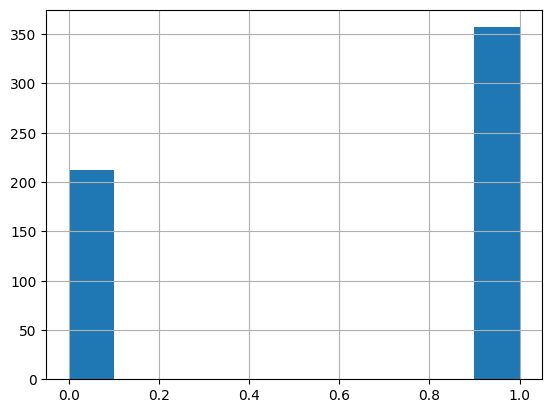

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

y.hist()

Un des points clés en machine learning est d'être capable de mesurer les performances de nos modèles. Pour cela, on va séparer notre ensemble entre un ensemble d'apprentissage `X_train, y_train` et un ensemble de test `X_test, y_test` dont on ne se servira par pour l'apprentissage et sur lequel on évaluera notre modèle.

d) Utiliser la fonction `train_test_split` de sklearn pour séparer le dataset enre un train et un test set. On prendra ici une taille de test set égale à 20% de l'échantillon total.

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.shape, X_test.shape

((455, 30), (114, 30))

e) Afficher les histogrammes du train et du test set (si possible sur une même figure). La répartition des classes doit être équivalente entre le train et le test set.

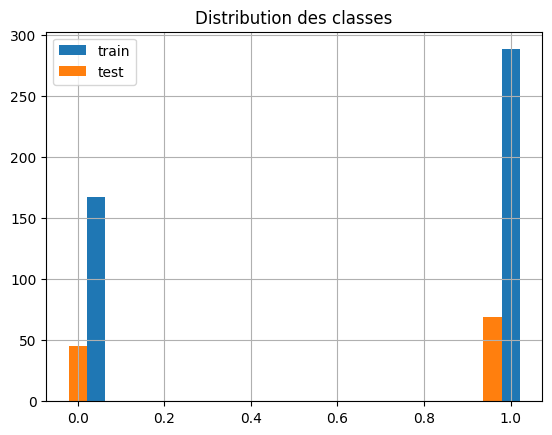

In [7]:
ax = y_train.hist(bins=24, label="train", align="right")
y_test.hist(bins=24, label="test", ax=ax, align="left")
ax.set_title("Distribution des classes")
ax.legend();

## 2 - Introduction à la régression logistique

On va utiliser un algorithme classique de machine learning en classification, la régression logistique. 

En régression logistique, on cherche à assigner à chaque échantillon $x$ une probabilité $p(x) \in [0,1]$, qui va être la probabilité que la classe soit égale à $1$ (ici probabilité que la masse soit bénigne). Pour obtenir des probabilités, on se sert de la fonction [sigmoïde](https://fr.wikipedia.org/wiki/Sigmo%C3%AFde_(math%C3%A9matiques)) :

$$\sigma(t) = \frac{1}{1 + e^{-t}}.$$

Cette fonction prend des valeurs entre $0$ et $1$ et a en fait les propriétés d'une fonction de répartition.

Notons $d$ la dimension du problème. En régression logistique, on calcule un vecteur $\beta \in \mathbb{R}^d$ et un biais $a \in \mathbb{R}$ et on exprime la probabilité d'être dans la classe $1$ pour un échantillon $x$ comme 

$$p(x) = \sigma(\beta^Tx + a) = \sigma( \beta_1 x_1 + \dots + \beta_d x_d + a). $$

Le classifieur correspondant est alors

$$ \hat{y} (x) = \begin{cases} 1 & \text{si } p(x) \geq 1/2 \\ 0 & \text{si } p(x) < 1/2. \end{cases} $$

a) Quelle est la nature géométrique de la frontière qui sépare les échantillons de $\mathbb{R}^d$ classifiés comme $0$ et ceux classifiés comme $1$ par le classifieur $\hat{y}$ ?

...

Entraîner un classifieur par régression logistique, c'est donc déterminer les paramètres $\beta, a \in \mathbb{R}^d \times \mathbb{R}$. On ne rentrera pas dans ce TP dans les détails de l'apprentissage, scikit-learn va le faire pour nous. Ce qu'il faut savoir est que $\beta,a$ sont obtenus en définissant une fonction de perte, et en utilisant ensuite un algorithme d'optimisation pour minimiser cette fonction de perte. 

b) Créer un classifieur `lr` par régression logistique, et l'entraîner sur les données `X_train, y_train`.

In [8]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

lr.fit(X_train, y_train)

C:\Users\joach\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

## 3 - Evaluation des performances

Maintenant qu'on a entraîné le classifieur `lr`, on va le tester et l'évaluer. 

a) Utiliser `lr` pour prédire un vecteur de classes `y_pred` à partir de l'ensemble de test `X_test`.

In [13]:
from time import time

t0 = time()
y_pred = lr.predict(X_test)
t1 = time()

print('Temps d\'exécution:', t1 - t0)

Temps d'exécution: 0.003778696060180664


Pour mesurer les performances du classifieur, on va comparer les classes prédites `y_pred` aux classes réelles `y_test`. Une mesure simple et naturelle est le taux d'erreur, c'est-à-dire la proportion d'échantillons $i$ pour lesquels `y_pred[i] != y_test[i]`. 

Remarque : ici `y_pred` va avoir le format d'un array numpy et `y_test` celui d'une série pandas. C'est donc plutôt `y_pred[i]` et `np.array(y_test)[i]` qu'on va comparer.

b) Calculer le taux d'erreur (le faire **à la main** et sans utiliser les fonctions toutes faites de scikit-learn).

In [14]:
type(y_pred)

numpy.ndarray

In [17]:
nb_erreur = 0

# on calcule le nombre d'erreurs de prédiction
for i in range(len(y_test)):
    if np.array(y_test)[i] != y_pred[i]:
        nb_erreur += 1
# et on calcule le taux d'erreur demandé
taux_erreur = nb_erreur / len (y_test)
print("Taux d'erreur :", taux_erreur)

Taux d'erreur : 0.06140350877192982


En machine learning, on utilise souvent l'accuracy, qui correspond plutôt au taux de succès.

c) Afficher l'accuracy de la prédiction (**à la main** encore une fois).

In [18]:
print("Accuracy :", 1 - taux_erreur)

Accuracy : 0.9385964912280702


Normalement, la plupart des échantillons ont été correctement classifiés. Cependant, l'évaluation par taux d'erreur/accuracy ne permet pas de savoir si les erreurs viennent d'échantillons $0$ classés comme $1$ ou d'échantillons $1$ classés comme $0$. Dans notre exemple de diagnostic du cancer du sein, c'est une nuance importante car il peut être plus grave de diagnostiquer une tumeur cancéreuse comme bénigne que l'inverse.

Une manière de visualiser cela est la matrice de confusion. Il s'agit d'une matrice carrée avec autant de lignes/colonnes que de classes (2 dans notre cas). Pour la ligne correspondant à la classe $i$, l'entrée $j$ contient le nombre d'échantillons dont la vraie classe est $i$ qui ont été classifiés comme $j$ par notre classifieur.

d) Construire **à la main** la matrice de confusion de notre prédiction, la stocker dans une dataframe et l'afficher.

In [19]:
matrice_confusion = [[0, 0], [0, 0]]
for i in range (len (y_test)):
    matrice_confusion [np.array(y_test)[i]] [y_pred[i]] += 1

confus = pd.DataFrame(matrice_confusion)

print(confus)

    0   1
0  40   5
1   2  67


## 4 - PCA et visualisation du dataset

On va maintenant chercher à visualiser le dataset. Pour pouvoir afficher les échantillons sur un plan, on va réduire les dimensions des échantillons de 30 à 2. Pour cela, on va se servir de l'analyse en composantes principales (PCA). 

a) Calculer un vecteur `X_train_pca` contenant les 2 composantes principales des données d'entraînement `X_train`. On se servira de la fonction `PCA` de scikit-learn. En utilisant la méthode `transform` de cette même pca, transformer `X_test` pour obtenir `X_test_pca`.

In [20]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

b) Créer un graphique représentant les exemples du train set en fonction de leurs composantes principales. Toutes les données doivent être de la même taille, représentées par un même symbole. 
Colorer en vert les échantillons bénins et en rouge les échantillons malins.

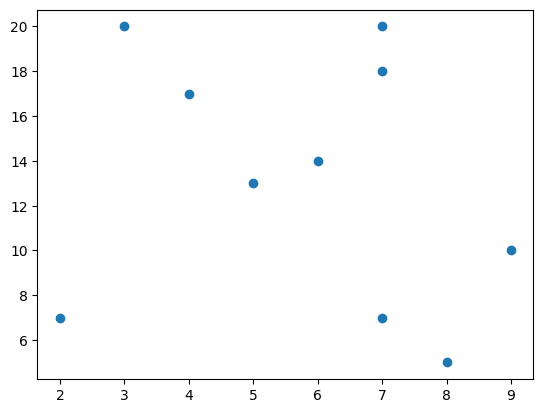

In [21]:
from random import randint
x = [randint (0, 10) for i in range(10)]
y = [randint (5, 20) for i in range(10)]
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(x, y)
plt.show()

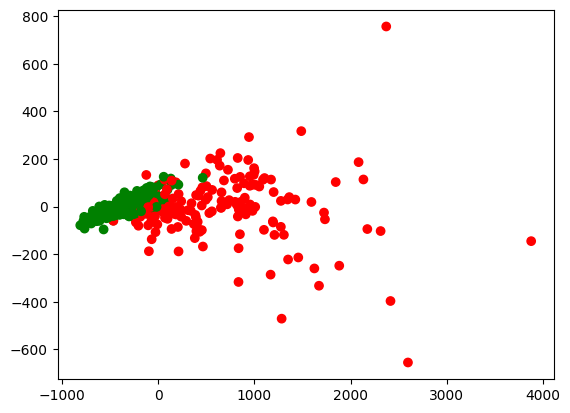

In [22]:
# Premier graphique

color = y_train
dcol = {0:'r', 1:'g'}
color = color.replace(dcol)

plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c = color)
plt.show()

c) On veut maintenant identifier les données de `X_test` qui sont mal prédites.
Refaites le même graphique en affichant cette fois les éléments de `X_test_pca` et en colorant les exemples en fonction de leur classe (comme précédemment). Cette fois-ci, vous indiquez les exemples mal classés en utilisant une forme particulière (à vous de choisir quelque chose de joli, qui se voit et qui se comprend au premier coup d'œil). 

In [23]:
# Deuxième graphique

# Il faut d'abord la liste des éléments mal classés

abscisse_correct = X_test_pca[y_test == y_pred][:,0]

ordonnee_correct = X_test_pca[y_test == y_pred][:,1]

classe_correct = y_test[y_test == y_pred]


abscisse_erreur = X_test_pca[y_test != y_pred][:,0]

ordonnee_erreur = X_test_pca[y_test != y_pred][:,1]

classe_erreur = y_test[y_test != y_pred]



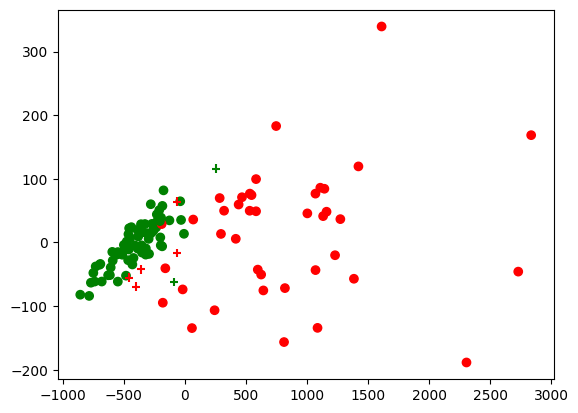

In [24]:
color_correct = classe_correct.replace(dcol)
color_erreur = classe_erreur.replace(dcol)

plt.scatter(abscisse_correct, ordonnee_correct, c = color_correct)
plt.scatter(abscisse_erreur, ordonnee_erreur, c = color_erreur, marker = '+')
plt.show()

d) Où semblent se trouver les points mal classifiés ?

...

La regression logistique estime la probabilité d'appartenance d'une donnée à chacune des classes. Cette probabilité donne une information quant à l'incertitude de cette prédiction. Pour une donnée, si toutes les probabilités sont faibles sauf une qui est presqu'égale à 1, alors la classe est (presque) certaine. Au contraire, pour certaines données, des probabilités significativement différentes de 0 et de 1 sont estimées ; dans ce cas, la prédiction de la classe est incertaine.
Ici, on dit que si une probabilité est < 0,9 ou > 0,1, alors la classe prédite pour cette donnée est incertaine.


e) Refaites le même graphique que précédemment. Cette fois-ci vous indiquez les exemples dont la classe est incertaine par une couleur, une taille ou une forme particulière (à votre choix, du moment que l'on voit et comprend au premier coup d'œil). Les probabilités associées aux échantillons pourront être obtenues avec la méthode `predict_proba` du classifieur `lr`.

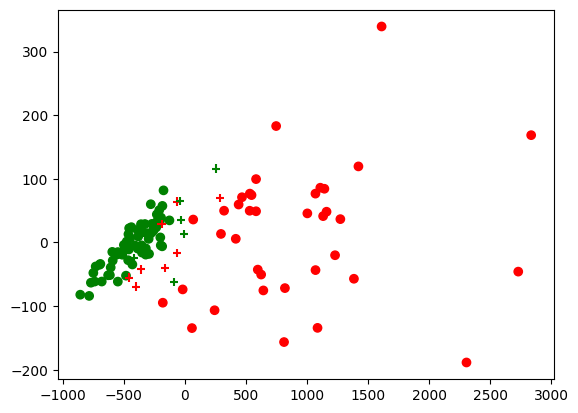

In [25]:
# Affichage de la confiance de prédiction

y_conf = np.max(lr.predict_proba(X_test), axis = 1)

abscisse_conf = X_test_pca[y_conf >= 0.9][:,0]
ordonnee_conf = X_test_pca[y_conf >= 0.9][:,1]
classe_conf = y_test[y_conf >= 0.9]
abscisse_unc = X_test_pca[y_conf < 0.9][:,0]
ordonnee_unc = X_test_pca[y_conf < 0.9][:,1]
classe_unc = y_test[y_conf < 0.9]


color_conf = classe_conf.replace(dcol)
color_unc = classe_unc.replace(dcol)

plt.scatter(abscisse_conf, ordonnee_conf, c = color_conf)
plt.scatter(abscisse_unc, ordonnee_unc, c = color_unc, marker = '+')
plt.show()

f) Où se situent les points pour lesquels la prédiction est incertaine ?

...

## 5 - Comparaison avec d'autres algorithmes de classification

On veut maintenant comparer notre prédiction par régression linéaire aux prédiction obtenues avec d'autres méthodes de classification. 

a) Entraîner un classifieur `knn` par k plus proches voisins et un classifieur `tree` par arbre binaire de décision sur les données `X_train, y_train`. On laissera les paramètres par défaut donnés par scikit-learn. Calculer les prédictions de ces deux classifieurs sur `X_test` et les mettre dans des vecteurs `y_pred_knn` et `y_pred_tree`.

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from time import time

knn = KNeighborsClassifier()

knn.fit(X_train, y_train)

t0 = time()
y_pred_knn = knn.predict(X_test)
t1 = time()

print(t1 - t0)


tree = DecisionTreeClassifier()

tree.fit(X_train,y_train)


t0 = time()
y_pred_tree = tree.predict(X_test)
t1 = time()

0.21387290954589844


b) Pour les prédictions `y_pred_knn` et `y_pred_tree`, calculer le taux d'erreur et l'accuracy.

c) Calculer la matrice de confusion pour ces deux prédictions.

In [20]:
matrice_confusion = [[0, 0], [0, 0]]
for i in range (len (y_test)):
    matrice_confusion [np.array(y_test)[i]] [y_pred_knn[i]] += 1

confus = pd.DataFrame(matrice_confusion)

print(confus)

    0   1
0  34   5
1   2  73


In [21]:
matrice_confusion = [[0, 0], [0, 0]]
for i in range (len (y_test)):
    matrice_confusion [np.array(y_test)[i]] [y_pred_tree[i]] += 1

confus = pd.DataFrame(matrice_confusion)

print(confus)

    0   1
0  34   5
1   3  72


d) Comparer brièvement les performances des trois classifieurs.

...

Bonus : e) Le nombre d'erreurs faites par les algorithmes est-il la seule chose qui permet de préférer un algorithme à d'autres ? Quels autre critères peuvent nous pousser à choisir un algorithme plutôt qu'un autre ?

## 6 - Visualisation des frontières de décision

Pour se faire une intuition des frontières de décision des différents types d'algorithmes, on va reprendre la PCA effectuée plus tôt et entraîner les modèles cette fois sur les 2 composantes principales `X_pca`. Attention, ce n'est donc pas la frontière de décision des algorithmes entraînés plus haut (en dimension 30) qu'on va visualiser, mais celles d'algorithmes entraînés en dimension 2.

a) Entraîner un classifieur par régression logistique `lr_pca` sur les données `X_train_pca, y_train`.

In [22]:
lr_pca = linear_model.LogisticRegression()

lr_pca.fit(X_train_pca, y_train)

LogisticRegression()

Le code suivant devrait afficher les zones classifiées comme $0$ et $1$ par `lr_pca`.

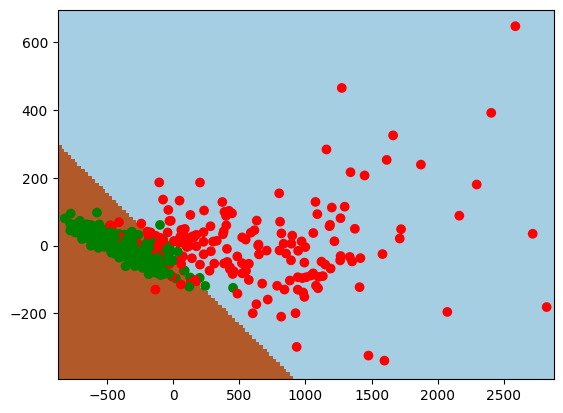

In [23]:
model = lr_pca

# Code issu d'un TP de Philippe Preux


h = 10  # pas de la grille
x_min = X_train_pca[:,0].min() - 50
x_max = X_train_pca[:,0].max() + 50
y_min = X_train_pca[:,1].min() - 50
y_max = X_train_pca[:,1].max() + 50
xx, yy = np.meshgrid (np.arange (x_min, x_max, h), np.arange (y_min, y_max, h))
# la grille est créée. Les coordonnées des intersections sont dans xx et yy

# on utilise ce modèle pour prédire la classe de chacun des exemples
Z2d = model. predict (np.c_[xx.ravel(), yy.ravel()])
# et on fait la figure
Z2d = Z2d. reshape (xx. shape)
plt. figure ()
plt. pcolormesh (xx, yy, Z2d, cmap=plt.cm.Paired)
# On définit la couleur des points
color = y_train
dcol = {0:'r', 1:'g'}
color = color.replace(dcol)
# On affiche les points
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c = color)
plt. show ()

b) Entraîner un classifieur par k plus proches voisins `knn_pca` et l'entraîner sur `X_pca, y_train`. Reprendre le code ci-dessus pour afficher les zones de décision dans le cas de `knn_pca`.

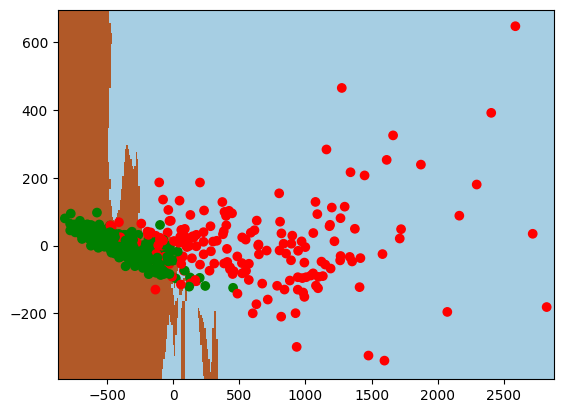

In [24]:
knn_pca = KNeighborsClassifier()

knn_pca.fit(X_train_pca, y_train)

model = knn_pca

h = 10  # pas de la grille
x_min = X_train_pca[:,0].min() - 50
x_max = X_train_pca[:,0].max() + 50
y_min = X_train_pca[:,1].min() - 50
y_max = X_train_pca[:,1].max() + 50
xx, yy = np.meshgrid (np.arange (x_min, x_max, h), np.arange (y_min, y_max, h))
# la grille est créée. Les coordonnées des intersections sont dans xx et yy

# on utilise ce modèle pour prédire la classe de chacun des exemples
Z2d = model. predict (np.c_[xx.ravel(), yy.ravel()])
# et on fait la figure
Z2d = Z2d. reshape (xx. shape)
plt. figure ()
plt. pcolormesh (xx, yy, Z2d, cmap=plt.cm.Paired)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c = color)
plt. show ()

c) Entraîner un classifieur par arbre de décision `tree_pca` et l'entraîner sur `X_pca, y_train`. A nouveau afficher les zones de décision dans le cas de `tree_pca`.

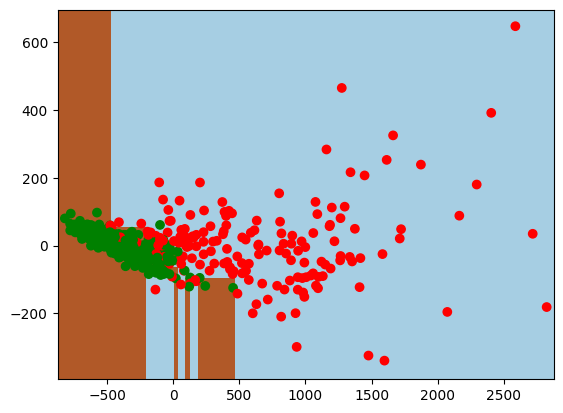

In [25]:
from sklearn.tree import DecisionTreeClassifier

tree_pca = DecisionTreeClassifier()

tree_pca.fit(X_train_pca,y_train)

model = tree_pca

h = 10  # pas de la grille
x_min = X_train_pca[:,0].min() - 50
x_max = X_train_pca[:,0].max() + 50
y_min = X_train_pca[:,1].min() - 50
y_max = X_train_pca[:,1].max() + 50
xx, yy = np.meshgrid (np.arange (x_min, x_max, h), np.arange (y_min, y_max, h))
# la grille est créée. Les coordonnées des intersections sont dans xx et yy

# on utilise ce modèle pour prédire la classe de chacun des exemples
Z2d = model. predict (np.c_[xx.ravel(), yy.ravel()])
# et on fait la figure
Z2d = Z2d. reshape (xx. shape)
plt. figure ()
plt. pcolormesh (xx, yy, Z2d, cmap=plt.cm.Paired)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c = color)
plt. show ()

## 7 - Courbe ROC

Implémenter la courbe ROC dans le cas binaire

In [26]:
import numpy as np

def calculate_roc_metrics(X_test, y_test, model):
    # Get the predicted class probabilities for the first n examples in df
    proba = model.predict_proba(X_test)[:, 1]

    # Sort the examples by class probabilities in decreasing order
    sorted_idx = np.argsort(-proba)

    # Calculate the number of positive examples in the first n examples in df
    n_positive = y_test.sum()
    n = y_test.shape[0]

    # Initialize arrays to store the true positive rate and false positive rate
    tpr = np.zeros(n)
    fpr = np.zeros(n)

    # Initialize variables to store the true positive count and false positive count
    tpc = 0
    fpc = 0

    for i, idx in enumerate(sorted_idx):
        
        # Increment the true positive count if the example is positive
        if y_test[idx] == 1:
            tpc += 1

        # Increment the false positive count if the example is negative
        else:
            fpc += 1

        # Calculate the true positive rate and false positive rate
        tpr[i] = tvp / n_positive
        fpr[i] = tfp / (n - n_positive)

    return tpr, fpr

In [27]:
tpr, fpr = calculate_roc_metrics(X_test, y_test, lr)

plt.plot(fpr,tpr)
plt.show()

KeyError: 3

Implémenter une fonction permettant de tracer la courbe ROC dans le cas multiclasse. Tracer les courbes ROC pour les 3 classes

In [ ]:
import numpy as np

def roc_multiclass(df, label, model):
    n = df.shape[0]
    
    df.iloc[:,-1] = (df.iloc[:,-1] == label)
    
    # Get the predicted class probabilities for the first n examples in df
    proba = model.predict_proba(df.iloc[:n, :-1])[:, label]
    
    # Sort the examples by class probabilities in decreasing order
    sorted_idx = np.argsort(-proba)

    # Calculate the number of positive examples in the first n examples in df
    n_positive = df.iloc[:n, -1].sum()

    # Initialize arrays to store the true positive rate and false positive rate
    tpr = np.zeros(n)
    fpr = np.zeros(n)

    # Initialize variables to store the true positive count and false positive count
    tvp = 0
    tfp = 0

    for i, idx in enumerate(sorted_idx):
        
        # Increment the true positive count if the example is positive
        if df.iloc[idx, -1] == 1:
            tvp += 1

        # Increment the false positive count if the example is negative
        else:
            tfp += 1

        # Calculate the true positive rate and false positive rate
        tpr[i] = tvp / n_positive
        fpr[i] = tfp / (n - n_positive)  # remplacer par (n - n_positive) ?

    return tpr, fpr

In [ ]:
# Classe 0

df_0 = df.replace(d)

tpr, fpr = roc_multiclass(df_0, 0, lr)

plt.plot(fpr, tpr)
plt.show()

In [ ]:
# Classe 1

df_0 = df.replace(d)

tpr, fpr = roc_multiclass(df_0, 1, lr)

plt.plot(fpr, tpr)
plt.show()

In [ ]:
# Classe 2

df_0 = df.replace(d)

tpr, fpr = roc_multiclass(df_0, 2, lr)

plt.plot(fpr, tpr)
plt.show()